# **Survival Analysis on ICU Dataset Using DeepSurv**

- Nama : Kurniawan Chandra Wijaya
- Universitas Gadjah Mada

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, FunctionTransformer

## **1. Data Preprocessing**
---

In [3]:
df = pd.read_csv('merged_dataICU.csv')
df

,file,ALP,ALT,AST,Age,Albumin,BUN,Bilirubin,Cholesterol,Creatinine,...,WBC,Weight,pH,MechVent,RecordID,SAPS-I,SOFA,Length_of_stay,Survival,In-hospital_death
0,132539,NaN,NaN,NaN,54.0,NaN,10.5,NaN,NaN,0.75,...,10.30,NaN,NaN,NaN,132539,6.0,1.0,5.0,NaN,0
1,132540,NaN,NaN,NaN,76.0,NaN,18.0,NaN,NaN,1.20,...,13.10,80.6,7.400,1.0,132540,16.0,8.0,8.0,NaN,0
2,132541,116.0,83.0,199.5,44.0,2.50,3.0,2.90,NaN,0.30,...,4.20,56.7,7.500,1.0,132541,21.0,11.0,19.0,NaN,0
3,132543,105.0,12.0,15.0,68.0,4.40,20.0,0.20,NaN,0.70,...,8.80,84.6,NaN,NaN,132543,7.0,1.0,9.0,575.0,0
4,132545,NaN,NaN,NaN,88.0,3.30,35.0,NaN,NaN,1.00,...,4.30,NaN,NaN,NaN,132545,17.0,2.0,4.0,918.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,163029,NaN,NaN,NaN,61.0,3.15,11.0,NaN,NaN,0.90,...,8.10,85.0,7.425,1.0,163029,18.0,8.0,17.0,NaN,0
11996,163033,NaN,NaN,NaN,51.0,NaN,5.5,NaN,NaN,0.50,...,5.15,208.0,7.340,NaN,163033,9.0,1.0,9.0,NaN,0
11997,163034,NaN,NaN,NaN,60.0,NaN,16.5,NaN,NaN,1.15,...,5.90,93.0,7.420,1.0,163034,13.0,10.0,8.0,NaN,0
11998,163035,116.5,451.5,541.5,71.0,NaN,45.5,2.95,NaN,2.80,...,23.90,128.3,7.415,NaN,163035,20.0,9.0,71.0,96.0,0


Fixing Censored Dataset:
- **The observation considered as censored observation** if survival > length of stay (not in hospital death). Such observations will considered as "unobserved".
- **The observation considered as complete observation** if survival < length of stay (in hospital death). Such observations will considered as "observed".

Our survival focus is mainly about death time **in hospital**.

In [4]:
# If Survival > Length_of_stay, then change Survival to Length_of_stay. Otherwise, keep Survival as is.
df['Survival'] = np.where(df['Survival'] > df['Length_of_stay'], df['Length_of_stay'], df['Survival'])

# Change if Survival is NaN and In-hospital_death is 0, then change Survival to Length_of_stay. Otherwise, keep Survival as is.
df['Survival'] = np.where((df['Survival'].isnull()) & (df['In-hospital_death'] == 0), df['Length_of_stay'], df['Survival'])

# Change In-hospital_death column name to observed
df = df.rename(columns={'In-hospital_death': 'observed'})

# Display data frame
display(df)

,file,ALP,ALT,AST,Age,Albumin,BUN,Bilirubin,Cholesterol,Creatinine,...,WBC,Weight,pH,MechVent,RecordID,SAPS-I,SOFA,Length_of_stay,Survival,observed
0,132539,NaN,NaN,NaN,54.0,NaN,10.5,NaN,NaN,0.75,...,10.30,NaN,NaN,NaN,132539,6.0,1.0,5.0,5.0,0
1,132540,NaN,NaN,NaN,76.0,NaN,18.0,NaN,NaN,1.20,...,13.10,80.6,7.400,1.0,132540,16.0,8.0,8.0,8.0,0
2,132541,116.0,83.0,199.5,44.0,2.50,3.0,2.90,NaN,0.30,...,4.20,56.7,7.500,1.0,132541,21.0,11.0,19.0,19.0,0
3,132543,105.0,12.0,15.0,68.0,4.40,20.0,0.20,NaN,0.70,...,8.80,84.6,NaN,NaN,132543,7.0,1.0,9.0,9.0,0
4,132545,NaN,NaN,NaN,88.0,3.30,35.0,NaN,NaN,1.00,...,4.30,NaN,NaN,NaN,132545,17.0,2.0,4.0,4.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,163029,NaN,NaN,NaN,61.0,3.15,11.0,NaN,NaN,0.90,...,8.10,85.0,7.425,1.0,163029,18.0,8.0,17.0,17.0,0
11996,163033,NaN,NaN,NaN,51.0,NaN,5.5,NaN,NaN,0.50,...,5.15,208.0,7.340,NaN,163033,9.0,1.0,9.0,9.0,0
11997,163034,NaN,NaN,NaN,60.0,NaN,16.5,NaN,NaN,1.15,...,5.90,93.0,7.420,1.0,163034,13.0,10.0,8.0,8.0,0
11998,163035,116.5,451.5,541.5,71.0,NaN,45.5,2.95,NaN,2.80,...,23.90,128.3,7.415,NaN,163035,20.0,9.0,71.0,71.0,0


In [5]:
# Display data Survival if null
df[df['Survival'].isnull()]

,file,ALP,ALT,AST,Age,Albumin,BUN,Bilirubin,Cholesterol,Creatinine,...,WBC,Weight,pH,MechVent,RecordID,SAPS-I,SOFA,Length_of_stay,Survival,observed
83,132744,NaN,NaN,NaN,70.0,NaN,NaN,NaN,NaN,NaN,...,NaN,95.3,7.37,1.0,132744,NaN,NaN,NaN,NaN,0
179,132992,NaN,NaN,NaN,23.0,NaN,NaN,NaN,NaN,NaN,...,NaN,81.0,7.40,NaN,132992,NaN,NaN,NaN,NaN,0
226,133140,67.0,25.0,19.0,58.0,NaN,8.0,0.8,NaN,1.0,...,4.6,107.0,NaN,NaN,133140,7.0,NaN,NaN,NaN,0
336,133396,NaN,NaN,NaN,77.0,NaN,NaN,NaN,NaN,NaN,...,NaN,54.4,NaN,NaN,133396,NaN,NaN,NaN,NaN,0
390,133534,NaN,NaN,NaN,80.0,NaN,NaN,NaN,NaN,NaN,...,NaN,73.0,NaN,NaN,133534,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11664,162193,NaN,NaN,NaN,40.0,NaN,NaN,NaN,NaN,NaN,...,NaN,61.9,NaN,NaN,162193,NaN,NaN,NaN,NaN,0
11760,162422,NaN,NaN,NaN,64.0,NaN,NaN,NaN,NaN,NaN,...,NaN,95.0,7.42,1.0,162422,NaN,NaN,NaN,NaN,0
11767,162432,NaN,NaN,NaN,72.0,NaN,NaN,NaN,NaN,NaN,...,NaN,97.5,NaN,NaN,162432,NaN,NaN,NaN,NaN,0
11825,162584,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,...,NaN,64.0,NaN,NaN,162584,NaN,NaN,NaN,NaN,0


In [6]:
# Drop rows with Survival as NaN
df = df.dropna(subset=['Survival'])
display(df)

,file,ALP,ALT,AST,Age,Albumin,BUN,Bilirubin,Cholesterol,Creatinine,...,WBC,Weight,pH,MechVent,RecordID,SAPS-I,SOFA,Length_of_stay,Survival,observed
0,132539,NaN,NaN,NaN,54.0,NaN,10.5,NaN,NaN,0.75,...,10.30,NaN,NaN,NaN,132539,6.0,1.0,5.0,5.0,0
1,132540,NaN,NaN,NaN,76.0,NaN,18.0,NaN,NaN,1.20,...,13.10,80.6,7.400,1.0,132540,16.0,8.0,8.0,8.0,0
2,132541,116.0,83.0,199.5,44.0,2.50,3.0,2.90,NaN,0.30,...,4.20,56.7,7.500,1.0,132541,21.0,11.0,19.0,19.0,0
3,132543,105.0,12.0,15.0,68.0,4.40,20.0,0.20,NaN,0.70,...,8.80,84.6,NaN,NaN,132543,7.0,1.0,9.0,9.0,0
4,132545,NaN,NaN,NaN,88.0,3.30,35.0,NaN,NaN,1.00,...,4.30,NaN,NaN,NaN,132545,17.0,2.0,4.0,4.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,163029,NaN,NaN,NaN,61.0,3.15,11.0,NaN,NaN,0.90,...,8.10,85.0,7.425,1.0,163029,18.0,8.0,17.0,17.0,0
11996,163033,NaN,NaN,NaN,51.0,NaN,5.5,NaN,NaN,0.50,...,5.15,208.0,7.340,NaN,163033,9.0,1.0,9.0,9.0,0
11997,163034,NaN,NaN,NaN,60.0,NaN,16.5,NaN,NaN,1.15,...,5.90,93.0,7.420,1.0,163034,13.0,10.0,8.0,8.0,0
11998,163035,116.5,451.5,541.5,71.0,NaN,45.5,2.95,NaN,2.80,...,23.90,128.3,7.415,NaN,163035,20.0,9.0,71.0,71.0,0


Check the missing values

In [7]:
# Display null values
df.isnull().sum()

file                  0
ALP                6775
ALT                6661
AST                6660
Age                   0
Albumin            7002
BUN                  61
Bilirubin          6659
Cholesterol       10919
Creatinine           61
DiasABP            3519
FiO2               3821
GCS                 176
Gender               12
Glucose             172
HCO3                 85
HCT                  68
HR                  175
Height             5646
ICUType               0
K                   127
Lactate            5297
MAP                3537
Mg                  170
NIDiasABP          1512
NIMAP              1513
NISysABP           1465
Na                   90
PaCO2              2885
PaO2               2886
Platelets            76
RespRate           8591
SaO2               6526
SysABP             3518
Temp                176
TroponinI         11302
TroponinT          9230
Urine               299
WBC                  91
Weight              899
pH                 2833
MechVent        

In [8]:
# Drop columns with more than 25% missing values
df = df.dropna(thresh=len(df)*0.75, axis=1)
display(df.isnull().sum())

file                 0
Age                  0
BUN                 61
Creatinine          61
GCS                176
Gender              12
Glucose            172
HCO3                85
HCT                 68
HR                 175
ICUType              0
K                  127
Mg                 170
NIDiasABP         1512
NIMAP             1513
NISysABP          1465
Na                  90
PaCO2             2885
PaO2              2886
Platelets           76
Temp               176
Urine              299
WBC                 91
Weight             899
pH                2833
RecordID             0
SAPS-I             395
SOFA               268
Length_of_stay      32
Survival             0
observed             0
dtype: int64

In [9]:
# Drop file and set RecordID as the first column
df = df.drop(columns=['file'])
df = df.set_index('RecordID')
display(df)

,Age,BUN,Creatinine,GCS,Gender,Glucose,HCO3,HCT,HR,ICUType,...,Temp,Urine,WBC,Weight,pH,SAPS-I,SOFA,Length_of_stay,Survival,observed
RecordID,,,,,,,,,,,,,,,,,,,,,
132539,54.0,10.5,0.75,15.0,0.0,160.0,27.0,33.50,73.0,4.0,...,37.70,100.0,10.30,NaN,NaN,6.0,1.0,5.0,5.0,0
132540,76.0,18.0,1.20,15.0,1.0,125.5,22.0,28.80,80.0,2.0,...,37.45,90.0,13.10,80.6,7.400,16.0,8.0,8.0,8.0,0
132541,44.0,3.0,0.30,5.0,0.0,141.0,25.0,28.70,85.5,3.0,...,37.85,100.0,4.20,56.7,7.500,21.0,11.0,19.0,19.0,0
132543,68.0,20.0,0.70,15.0,1.0,117.0,28.0,36.80,74.0,3.0,...,36.40,625.0,8.80,84.6,NaN,7.0,1.0,9.0,9.0,0
132545,88.0,35.0,1.00,15.0,0.0,102.5,19.0,30.60,73.0,3.0,...,37.00,50.0,4.30,NaN,NaN,17.0,2.0,4.0,4.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163029,61.0,11.0,0.90,10.0,0.0,118.0,28.0,27.20,85.0,4.0,...,37.50,140.0,8.10,85.0,7.425,18.0,8.0,17.0,17.0,0
163033,51.0,5.5,0.50,15.0,0.0,106.5,33.5,48.05,95.0,3.0,...,37.00,85.0,5.15,208.0,7.340,9.0,1.0,9.0,9.0,0
163034,60.0,16.5,1.15,9.0,0.0,126.0,25.5,25.40,83.0,4.0,...,38.15,105.0,5.90,93.0,7.420,13.0,10.0,8.0,8.0,0


SAPS-I and SOFA contains aggregation from other variables. Thus, SAPS-I and SOFA would be dropped.

In [10]:
# Drop SAPS-I and SOFA
df = df.drop(columns=['SAPS-I', 'SOFA'])
display(df)

,Age,BUN,Creatinine,GCS,Gender,Glucose,HCO3,HCT,HR,ICUType,...,PaO2,Platelets,Temp,Urine,WBC,Weight,pH,Length_of_stay,Survival,observed
RecordID,,,,,,,,,,,,,,,,,,,,,
132539,54.0,10.5,0.75,15.0,0.0,160.0,27.0,33.50,73.0,4.0,...,NaN,203.0,37.70,100.0,10.30,NaN,NaN,5.0,5.0,0
132540,76.0,18.0,1.20,15.0,1.0,125.5,22.0,28.80,80.0,2.0,...,153.0,181.0,37.45,90.0,13.10,80.6,7.400,8.0,8.0,0
132541,44.0,3.0,0.30,5.0,0.0,141.0,25.0,28.70,85.5,3.0,...,120.5,84.0,37.85,100.0,4.20,56.7,7.500,19.0,19.0,0
132543,68.0,20.0,0.70,15.0,1.0,117.0,28.0,36.80,74.0,3.0,...,NaN,315.0,36.40,625.0,8.80,84.6,NaN,9.0,9.0,0
132545,88.0,35.0,1.00,15.0,0.0,102.5,19.0,30.60,73.0,3.0,...,NaN,103.0,37.00,50.0,4.30,NaN,NaN,4.0,4.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163029,61.0,11.0,0.90,10.0,0.0,118.0,28.0,27.20,85.0,4.0,...,163.0,195.0,37.50,140.0,8.10,85.0,7.425,17.0,17.0,0
163033,51.0,5.5,0.50,15.0,0.0,106.5,33.5,48.05,95.0,3.0,...,71.0,155.0,37.00,85.0,5.15,208.0,7.340,9.0,9.0,0
163034,60.0,16.5,1.15,9.0,0.0,126.0,25.5,25.40,83.0,4.0,...,136.0,99.0,38.15,105.0,5.90,93.0,7.420,8.0,8.0,0


### **1.1. Missing Value Analysis**
For features that contains less than 25% of missing values, it is better to analysis missing values.

<Axes: >

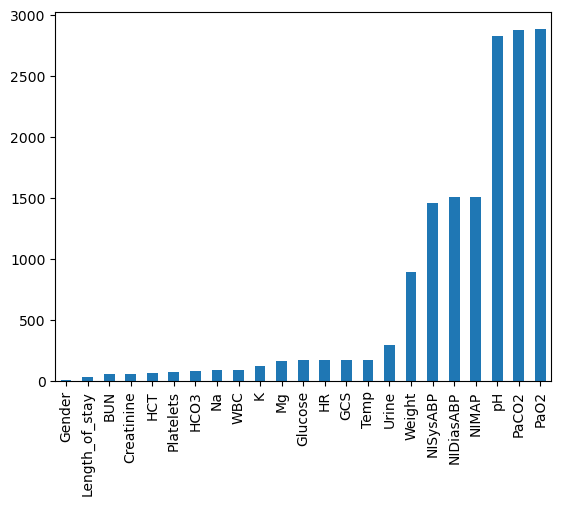

In [11]:
# Missing Value Analysis
missing = df.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

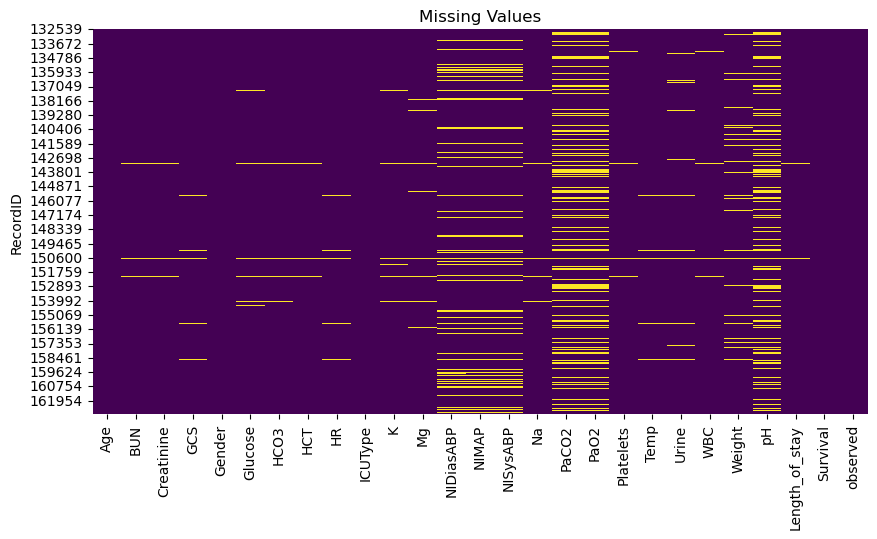

In [12]:
# Missing Value Plot
plt.figure(figsize=(10, 5))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values')
plt.show()

In [13]:
# Remove rows with missing values more than 50%
df = df.dropna(thresh=len(df.columns)*0.5)
display(df.isnull().sum())

Age                  0
BUN                 43
Creatinine          43
GCS                165
Gender              11
Glucose            152
HCO3                65
HCT                 50
HR                 165
ICUType              0
K                  109
Mg                 151
NIDiasABP         1500
NIMAP             1501
NISysABP          1453
Na                  70
PaCO2             2867
PaO2              2868
Platelets           57
Temp               165
Urine              288
WBC                 72
Weight             885
pH                2815
Length_of_stay      19
Survival             0
observed             0
dtype: int64

### **1.2. Train and Test Splitting**
In order to avoid data leakage, it is preferable to split the data first.

In [14]:
# Train and Test Split for Survival Data with Censoring
from sklearn.model_selection import train_test_split

# Split data into training and test sets
train, test = train_test_split(df, test_size=0.2, random_state=42)


In [15]:
X_train = train.drop(columns=['Survival', 'observed', 'Length_of_stay'])
y_train = train[['Survival', 'observed']]
X_test = test.drop(columns=['Survival', 'observed', 'Length_of_stay'])
y_test = test[['Survival', 'observed']]

In [16]:
X_train

,Age,BUN,Creatinine,GCS,Gender,Glucose,HCO3,HCT,HR,ICUType,...,NISysABP,Na,PaCO2,PaO2,Platelets,Temp,Urine,WBC,Weight,pH
RecordID,,,,,,,,,,,,,,,,,,,,,
160362,85.0,24.0,1.10,8.0,1.0,163.5,22.5,26.85,97.0,1.0,...,0.0,136.0,34.5,163.5,139.0,37.75,80.0,12.80,88.0,7.43
135595,86.0,18.0,1.10,10.0,1.0,141.5,22.0,26.50,75.0,4.0,...,149.0,139.0,33.0,170.0,101.5,37.20,90.0,10.15,70.0,7.45
157030,55.0,15.0,0.85,15.0,1.0,108.5,27.0,22.90,91.0,2.0,...,107.0,136.5,40.0,163.0,336.0,37.30,80.0,16.30,74.1,7.37
146894,86.0,23.0,1.35,14.0,1.0,128.5,25.0,25.50,82.0,2.0,...,NaN,137.0,42.0,297.0,76.0,36.90,40.0,16.25,90.4,7.36
147601,90.0,13.0,0.60,13.0,0.0,109.0,25.0,27.60,70.0,4.0,...,133.0,131.0,40.0,100.0,246.5,36.50,120.0,8.85,NaN,7.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161618,84.0,22.5,0.65,12.5,0.0,150.5,27.0,27.50,72.0,2.0,...,NaN,143.0,41.0,171.0,166.0,37.05,60.0,9.70,52.3,7.44
145897,56.0,17.5,0.90,15.0,1.0,150.5,25.5,43.95,67.5,1.0,...,127.0,137.0,NaN,NaN,170.0,36.65,400.0,11.15,98.9,NaN
146365,80.0,19.0,0.90,15.0,1.0,105.0,23.5,25.70,87.0,4.0,...,113.0,141.0,NaN,NaN,211.0,36.70,55.0,10.70,NaN,NaN


### **1.3. Missing Value Imputation**
Imputation would be done by specifying features into two category: features with missing value > 10% and otherwise.

In [17]:
# Get features with missing values > 10% and otherwise in the training set
pi_features = X_train.columns[X_train.isnull().sum() > 0.1*len(train)]
si_features = X_train.columns[X_train.isnull().sum() <= 0.1*len(train)]

# Display
display(pi_features, si_features)

Index(['NIDiasABP', 'NIMAP', 'NISysABP', 'PaCO2', 'PaO2', 'pH'], dtype='object')

Index(['Age', 'BUN', 'Creatinine', 'GCS', 'Gender', 'Glucose', 'HCO3', 'HCT',
       'HR', 'ICUType', 'K', 'Mg', 'Na', 'Platelets', 'Temp', 'Urine', 'WBC',
       'Weight'],
      dtype='object')

#### **1.3.1. Imputation Exploration**

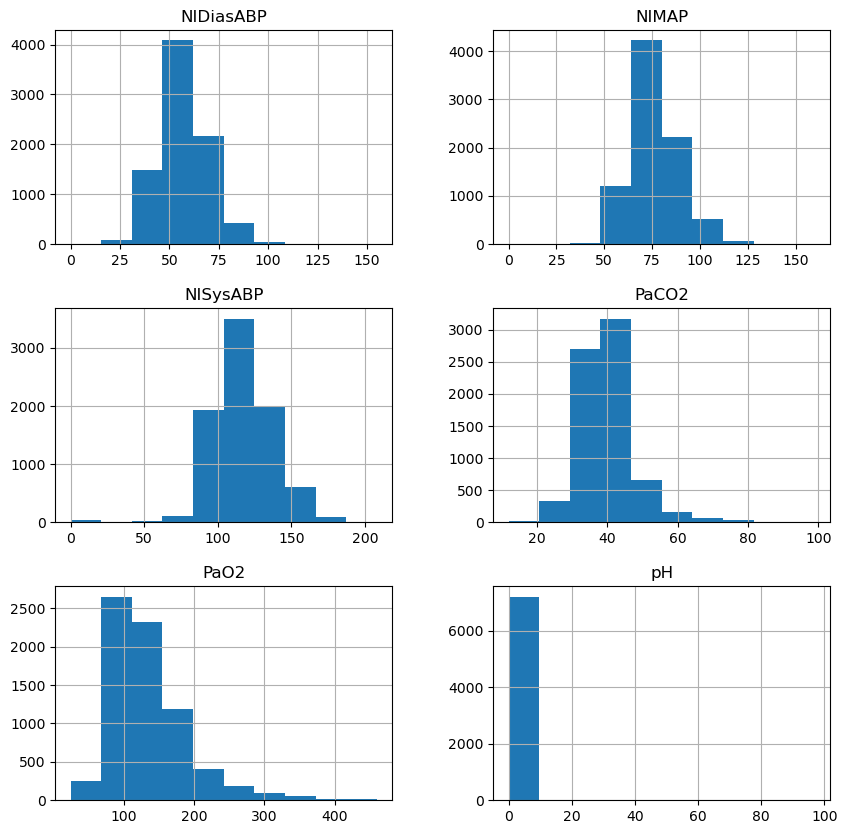

In [18]:
# Show histogram of the features with missing values > 10%
X_train[pi_features].hist(figsize=(10, 10))
plt.show()

> Some of the data are skewed, only NISysABP tended to be normally distributed due to its symmetrical shape.

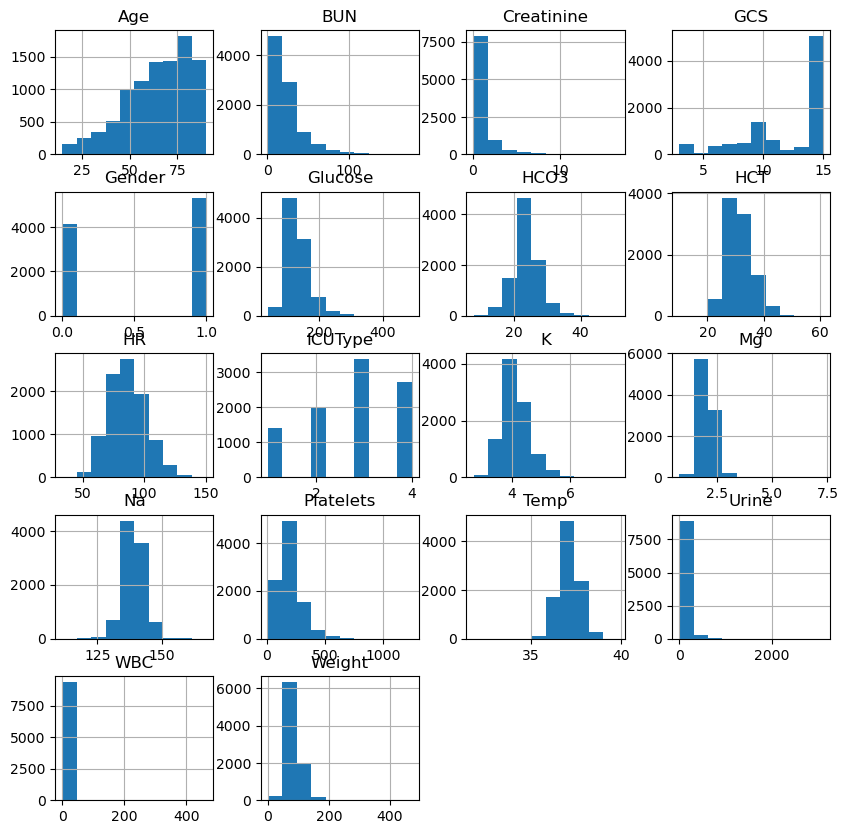

In [19]:
# Show histogram of the features with missing values <= 10%
X_train[si_features].hist(figsize=(10, 10))
plt.show()

> Most of the data are skewed.

In order to avoiding data leakage, pipeline opearator will be used.

In [20]:
# Define the transformers
simple_imputer = SimpleImputer(strategy='median')
predictive_imputer = IterativeImputer()

# Pipeline for imputing and encoding columns with < 100 missing values
preprocessor_less_than_10 = Pipeline(steps=[
    ('simple_imputer', simple_imputer),
])

# Preprocessor to handle the columns separately
initial_preprocessor = ColumnTransformer(transformers=[
    ('imputer_less_10', preprocessor_less_than_10, si_features),
], remainder='passthrough')

# Final pipeline to apply the initial preprocessor and then impute
final_pipeline = Pipeline(steps=[
    ('initial_preprocessor', initial_preprocessor),
    ('iterative_imputer', predictive_imputer),
])

In [21]:
X_train = final_pipeline.fit_transform(X_train)
X_test = final_pipeline.transform(X_test)

c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [22]:
X_train

array([[ 85.        ,  24.        ,   1.1       , ...,  34.5       ,
        163.5       ,   7.43      ],
       [ 86.        ,  18.        ,   1.1       , ...,  33.        ,
        170.        ,   7.45      ],
       [ 55.        ,  15.        ,   0.85      , ...,  40.        ,
        163.        ,   7.37      ],
       ...,
       [ 80.        ,  19.        ,   0.9       , ...,  36.76310931,
        141.27332464,   7.44385604],
       [ 84.        ,  37.        ,   1.4       , ...,  37.        ,
         47.        ,   7.44      ],
       [ 90.        ,  26.        ,   1.4       , ...,  40.        ,
        117.        ,   7.39      ]])

In [23]:
si_features

Index(['Age', 'BUN', 'Creatinine', 'GCS', 'Gender', 'Glucose', 'HCO3', 'HCT',
       'HR', 'ICUType', 'K', 'Mg', 'Na', 'Platelets', 'Temp', 'Urine', 'WBC',
       'Weight'],
      dtype='object')

In [24]:
X_train = pd.DataFrame(X_train, columns=df.columns.drop(['Survival', 'observed', 'Length_of_stay']))
X_test = pd.DataFrame(X_test, columns=df.columns.drop(['Survival', 'observed', 'Length_of_stay']))
display(X_train)

,Age,BUN,Creatinine,GCS,Gender,Glucose,HCO3,HCT,HR,ICUType,...,NISysABP,Na,PaCO2,PaO2,Platelets,Temp,Urine,WBC,Weight,pH
0,85.0,24.0,1.10,8.0,1.0,163.5,22.5,26.85,97.0,1.0,...,37.75,80.0,12.80,88.0,18.595358,15.304437,0.000000,34.500000,163.500000,7.430000
1,86.0,18.0,1.10,10.0,1.0,141.5,22.0,26.50,75.0,4.0,...,37.20,90.0,10.15,70.0,71.500000,97.335000,149.000000,33.000000,170.000000,7.450000
2,55.0,15.0,0.85,15.0,1.0,108.5,27.0,22.90,91.0,2.0,...,37.30,80.0,16.30,74.1,53.000000,70.330000,107.000000,40.000000,163.000000,7.370000
3,86.0,23.0,1.35,14.0,1.0,128.5,25.0,25.50,82.0,2.0,...,36.90,40.0,16.25,90.4,51.967349,70.794809,115.786769,42.000000,297.000000,7.360000
4,90.0,13.0,0.60,13.0,0.0,109.0,25.0,27.60,70.0,4.0,...,36.50,120.0,8.85,80.0,53.000000,72.000000,133.000000,40.000000,100.000000,7.460000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9470,84.0,22.5,0.65,12.5,0.0,150.5,27.0,27.50,72.0,2.0,...,37.05,60.0,9.70,52.3,51.704155,74.365983,122.265712,41.000000,171.000000,7.440000
9471,56.0,17.5,0.90,15.0,1.0,150.5,25.5,43.95,67.5,1.0,...,36.65,400.0,11.15,98.9,72.000000,90.670000,127.000000,39.979481,140.140722,7.425129
9472,80.0,19.0,0.90,15.0,1.0,105.0,23.5,25.70,87.0,4.0,...,36.70,55.0,10.70,80.0,45.000000,66.000000,113.000000,36.763109,141.273325,7.443856
9473,84.0,37.0,1.40,14.0,1.0,129.0,22.0,28.80,75.0,3.0,...,36.70,100.0,16.10,77.5,66.500000,83.000000,119.000000,37.000000,47.000000,7.440000


## **2. Exploratory Data Analysis**
---

### **2.1. Censoring Distribution**

c:\Users\ASUS\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


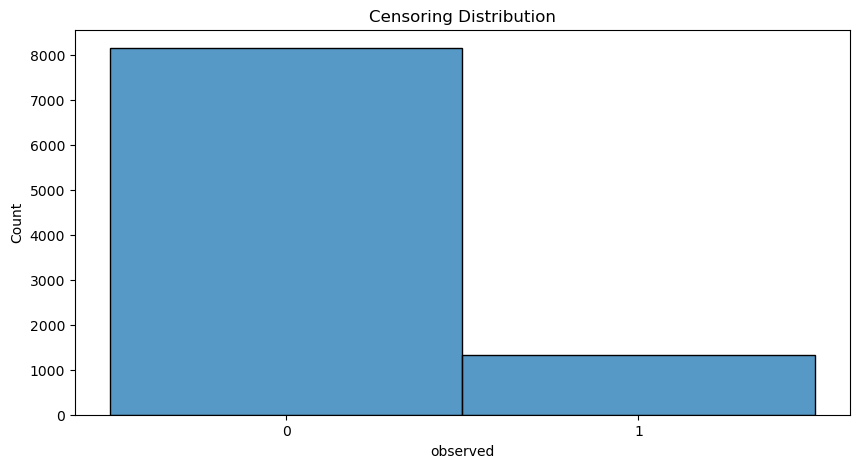

In [25]:
plt.figure(figsize=(10, 5))
sns.histplot(y_train['observed'].astype(str))
plt.title('Censoring Distribution')
plt.show()

We can conclude that there's a lot of censored data.

### **2.2. Multicollinearity Check by Correlation Heatmap**

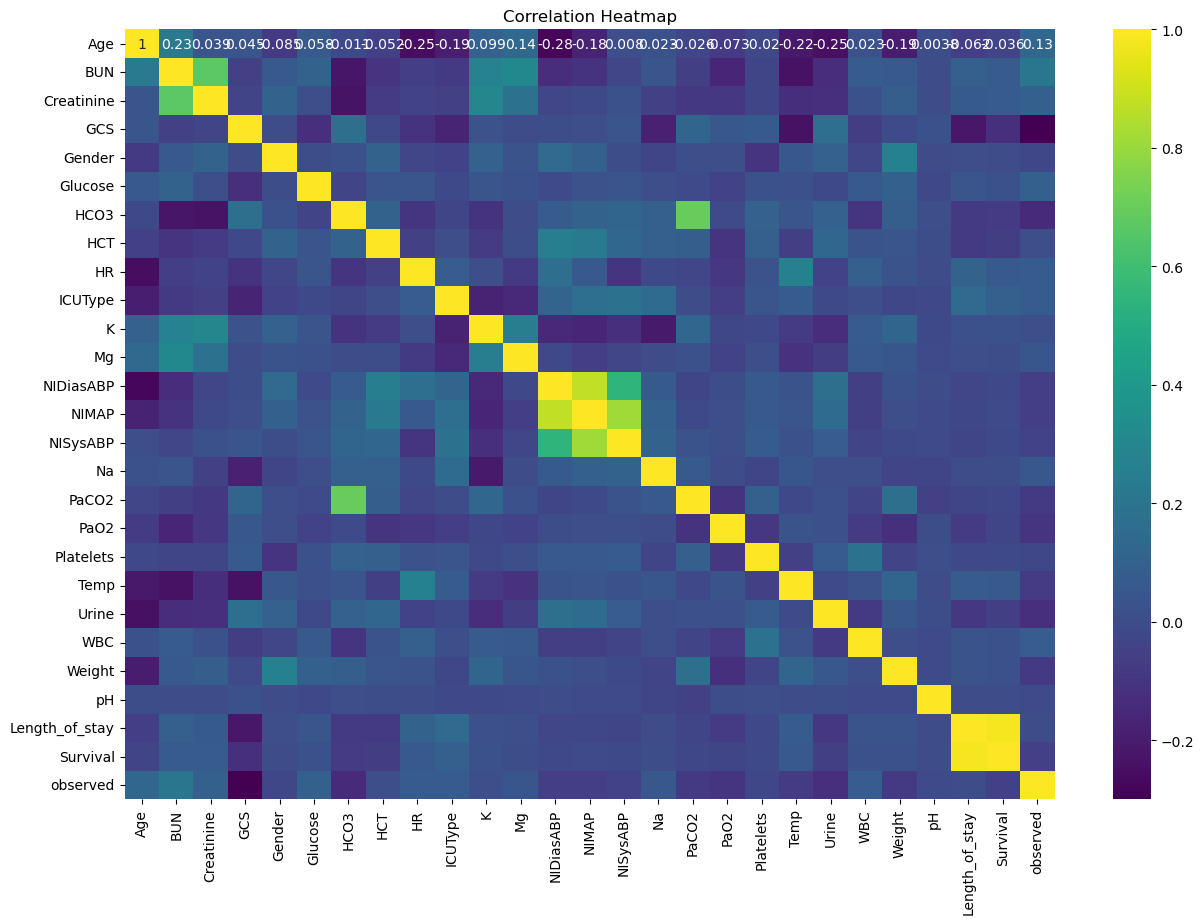

In [26]:
plt.figure(figsize=(15, 10))
sns.heatmap(df.corr(), annot=True, cmap='viridis')
plt.title('Correlation Heatmap')
plt.show()

There's high correlation between NIDiasABP, NIMAP, abd NISysABP.

## **2.3. Survival Curve**

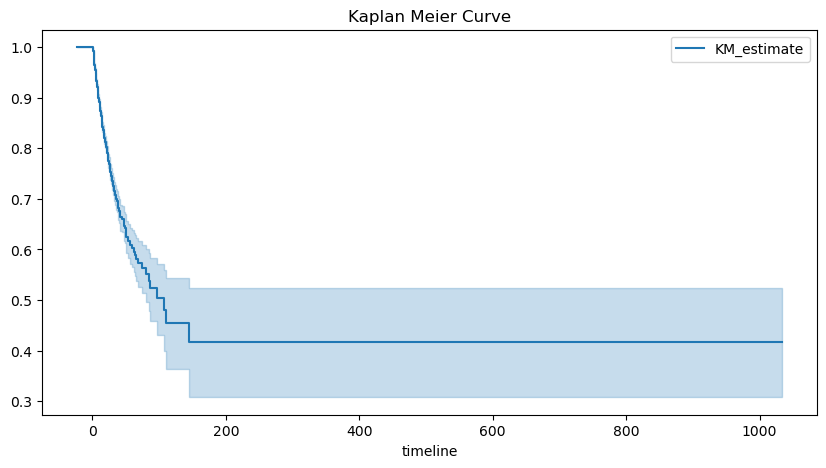

In [67]:
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()


kmf.fit(durations=train['Survival'], event_observed=train['observed'])

# Plot the Kaplan Meier Curve
plt.figure(figsize=(10, 5))
kmf.plot()
plt.title('Kaplan Meier Curve')
plt.show()

## **3. Modelling**
---

In [27]:
import torch
import torchtuples as tt
from pycox.models import CoxPH, CoxTime
from pycox.models.cox_time import MLPVanillaCoxTime
from pycox.evaluation import EvalSurv

In [28]:
from copy import deepcopy as dc

In [29]:
from sklearn.preprocessing import StandardScaler

In [30]:
y_train

,Survival,observed
RecordID,,
160362,7.0,0
135595,24.0,0
157030,6.0,0
146894,7.0,0
147601,10.0,0
...,...,...
161618,15.0,0
145897,2.0,0
146365,6.0,0


In [31]:
# Merge X_train and y_train
train = X_train.copy().reset_index(drop=True)
train['Survival'] = y_train['Survival'].reset_index(drop=True)
train['observed'] = y_train['observed'].reset_index(drop=True)

# Merge X_test and y_test
test = X_test.copy()
test['Survival'] = y_test['Survival'].reset_index(drop=True)
test['observed'] = y_test['observed'].reset_index(drop=True)

In [32]:
test

,Age,BUN,Creatinine,GCS,Gender,Glucose,HCO3,HCT,HR,ICUType,...,PaCO2,PaO2,Platelets,Temp,Urine,WBC,Weight,pH,Survival,observed
0,79.0,18.0,0.70,15.0,1.0,110.0,19.0,36.60,102.5,3.0,...,13.15,95.3,66.000000,76.000000,111.000000,30.572147,126.333422,7.418131,14.0,0
1,76.0,15.5,0.70,6.0,1.0,74.0,21.0,32.50,83.0,3.0,...,6.20,75.0,56.500000,76.000000,111.500000,42.500000,153.500000,7.330000,5.0,0
2,87.0,29.0,1.05,11.0,0.0,110.5,16.0,32.60,107.0,4.0,...,14.35,3.4,84.000000,94.000000,120.000000,24.000000,183.000000,7.420000,8.0,1
3,31.0,108.5,2.30,9.0,0.0,100.5,25.0,25.00,119.5,3.0,...,4.40,95.7,75.000000,88.000000,135.500000,48.500000,119.000000,7.385000,6.0,1
4,84.0,7.0,0.75,14.0,0.0,114.0,21.5,29.10,63.5,4.0,...,12.70,57.0,38.000000,78.335000,155.000000,39.000000,110.000000,7.355000,15.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2364,66.0,18.5,1.20,15.0,1.0,115.5,29.0,39.15,113.0,2.0,...,10.75,102.0,55.000000,73.330000,108.000000,45.561994,113.864368,7.439691,6.0,0
2365,73.0,40.0,2.50,10.0,1.0,204.0,29.0,32.80,80.0,3.0,...,8.90,87.3,59.000000,71.000000,112.000000,44.000000,108.000000,7.460000,7.0,0
2366,50.0,12.5,0.45,15.0,0.0,108.0,26.0,31.10,107.0,3.0,...,12.20,80.0,57.000000,70.500000,107.000000,36.661091,135.458400,7.506874,13.0,0
2367,71.0,14.0,1.00,15.0,1.0,106.0,26.0,31.30,87.5,2.0,...,14.50,85.9,45.000000,64.000000,101.000000,44.000000,166.000000,7.390000,9.0,0


In [33]:
ssc = StandardScaler()
x_train = ssc.fit_transform(train.drop(columns=['Survival', 'observed'])).astype('float32')
x_test = ssc.transform(test.drop(columns=['Survival', 'observed'])).astype('float32')

In [34]:
get_target = lambda df: (df['Survival'].values, df['observed'].values)
y_train = get_target(train)
y_test = get_target(test)
durations_test, events_test = get_target(test)
testt = x_test, y_test

In [35]:
test

,Age,BUN,Creatinine,GCS,Gender,Glucose,HCO3,HCT,HR,ICUType,...,PaCO2,PaO2,Platelets,Temp,Urine,WBC,Weight,pH,Survival,observed
0,79.0,18.0,0.70,15.0,1.0,110.0,19.0,36.60,102.5,3.0,...,13.15,95.3,66.000000,76.000000,111.000000,30.572147,126.333422,7.418131,14.0,0
1,76.0,15.5,0.70,6.0,1.0,74.0,21.0,32.50,83.0,3.0,...,6.20,75.0,56.500000,76.000000,111.500000,42.500000,153.500000,7.330000,5.0,0
2,87.0,29.0,1.05,11.0,0.0,110.5,16.0,32.60,107.0,4.0,...,14.35,3.4,84.000000,94.000000,120.000000,24.000000,183.000000,7.420000,8.0,1
3,31.0,108.5,2.30,9.0,0.0,100.5,25.0,25.00,119.5,3.0,...,4.40,95.7,75.000000,88.000000,135.500000,48.500000,119.000000,7.385000,6.0,1
4,84.0,7.0,0.75,14.0,0.0,114.0,21.5,29.10,63.5,4.0,...,12.70,57.0,38.000000,78.335000,155.000000,39.000000,110.000000,7.355000,15.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2364,66.0,18.5,1.20,15.0,1.0,115.5,29.0,39.15,113.0,2.0,...,10.75,102.0,55.000000,73.330000,108.000000,45.561994,113.864368,7.439691,6.0,0
2365,73.0,40.0,2.50,10.0,1.0,204.0,29.0,32.80,80.0,3.0,...,8.90,87.3,59.000000,71.000000,112.000000,44.000000,108.000000,7.460000,7.0,0
2366,50.0,12.5,0.45,15.0,0.0,108.0,26.0,31.10,107.0,3.0,...,12.20,80.0,57.000000,70.500000,107.000000,36.661091,135.458400,7.506874,13.0,0
2367,71.0,14.0,1.00,15.0,1.0,106.0,26.0,31.30,87.5,2.0,...,14.50,85.9,45.000000,64.000000,101.000000,44.000000,166.000000,7.390000,9.0,0


### **3.1. DeepSurv**

In [36]:
??tt.practical.MLPVanilla

Init signature:
tt.practical.MLPVanilla(
    in_features,
    num_nodes,
    out_features,
    batch_norm=True,
    dropout=None,
    activation=<class 'torch.nn.modules.activation.ReLU'>,
    output_activation=None,
    output_bias=True,
    w_init_=<function MLPVanilla.<lambda> at 0x000001F0BF513A60>,
)
Docstring:     
Base class for all neural network modules.

Your models should also subclass this class.

Modules can also contain other Modules, allowing to nest them in
a tree structure. You can assign the submodules as regular attributes::

    import torch.nn as nn
    import torch.nn.functional as F

    class Model(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(1, 20, 5)
            self.conv2 = nn.Conv2d(20, 20, 5)

        def forward(self, x):
            x = F.relu(self.conv1(x))
            return F.relu(self.conv2(x))

Submodules assigned in this way will be registered, and will have their
parameters converted too 

In [37]:
in_features = x_train.shape[1]
num_nodes = [2048, 2048]
out_features = 1
batch_norm = True
dropout = 0.1
output_bias = False
net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias=output_bias)

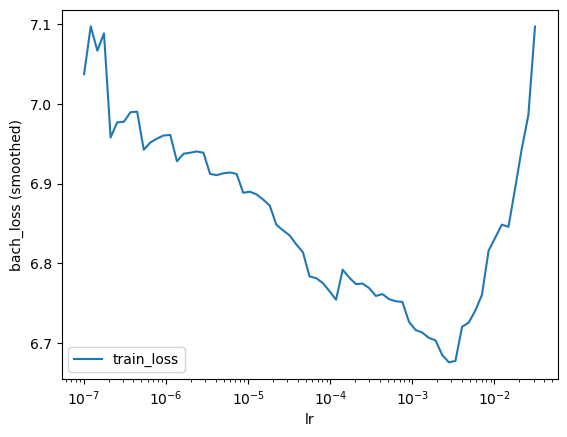

In [38]:
model = CoxPH(net, tt.optim.Adam)
batch_size = 2048
lrfinder = model.lr_finder(x_train, y_train, batch_size, tolerance=10)
_ = lrfinder.plot()

In [39]:
lrfinder.get_best_lr()

0.0002782559402207136

In [40]:
model.optimizer.set_lr(0.000110)

In [41]:
epochs = 3000
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=testt, val_batch_size=batch_size)

0:	[1s / 1s],		train_loss: 6.5997,	val_loss: 5.6267
1:	[1s / 2s],		train_loss: 6.7183,	val_loss: 5.6755
2:	[1s / 3s],		train_loss: 6.3657,	val_loss: 5.6668
3:	[1s / 5s],		train_loss: 6.3021,	val_loss: 5.5779
4:	[1s / 6s],		train_loss: 6.2327,	val_loss: 5.5222
5:	[1s / 7s],		train_loss: 6.1877,	val_loss: 5.5242
6:	[1s / 8s],		train_loss: 6.1815,	val_loss: 5.5277
7:	[1s / 10s],		train_loss: 6.1200,	val_loss: 5.5268
8:	[1s / 11s],		train_loss: 6.0885,	val_loss: 5.5050
9:	[1s / 12s],		train_loss: 6.0523,	val_loss: 5.4920
10:	[1s / 14s],		train_loss: 6.0315,	val_loss: 5.4891
11:	[1s / 15s],		train_loss: 6.0155,	val_loss: 5.5014
12:	[1s / 16s],		train_loss: 5.9825,	val_loss: 5.5098
13:	[1s / 17s],		train_loss: 5.9623,	val_loss: 5.5051
14:	[1s / 19s],		train_loss: 5.9606,	val_loss: 5.5016
15:	[1s / 20s],		train_loss: 5.9233,	val_loss: 5.5030
16:	[1s / 21s],		train_loss: 5.9107,	val_loss: 5.4919
17:	[1s / 23s],		train_loss: 5.8934,	val_loss: 5.5024
18:	[1s / 24s],		train_loss: 5.8701,	val_loss

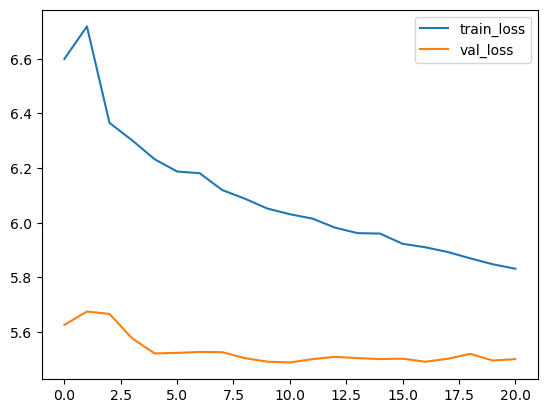

In [42]:
_ = log.plot()

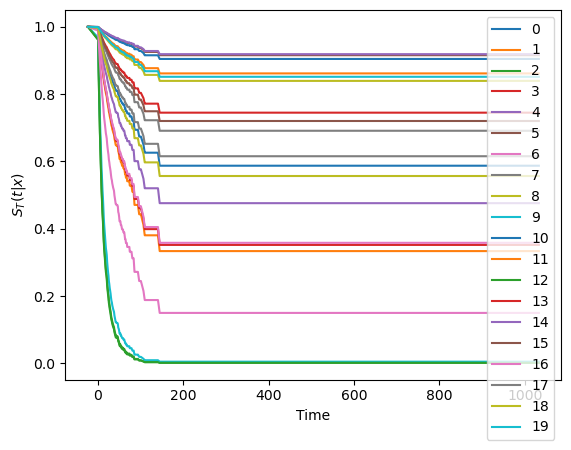

In [43]:
_ = model.compute_baseline_hazards()
surv = model.predict_surv_df(x_test)
surv.iloc[:, :20].plot()
plt.ylabel('$S_T(t | x)$')
_ = plt.xlabel('Time')

**Concordance Index**

In [44]:
from pycox.evaluation import EvalSurv

---
Import EvalSurv manually because there is error

In [45]:

import warnings
import numpy as np
import pandas as pd
from pycox.evaluation.concordance import concordance_td
from pycox.evaluation import ipcw, admin
from pycox import utils


class EvalSurv:
    """Class for evaluating predictions.
    
    Arguments:
        surv {pd.DataFrame} -- Survival predictions.
        durations {np.array} -- Durations of test set.
        events {np.array} -- Events of test set.

    Keyword Arguments:
        censor_surv {str, pd.DataFrame, EvalSurv} -- Censoring distribution.
            If provided data frame (survival function for censoring) or EvalSurv object,
            this will be used. 
            If 'km', we will fit a Kaplan-Meier to the dataset.
            (default: {None})
        censor_durations {np.array}: -- Administrative censoring times. (default: {None})
        steps {str} -- For durations between values of `surv.index` choose the higher index 'pre'
            or lower index 'post'. For a visualization see `help(EvalSurv.steps)`. (default: {'post'})
    """
    def __init__(self, surv, durations, events, censor_surv=None, censor_durations=None, steps='post'):
        assert (type(durations) == type(events) == np.ndarray), 'Need `durations` and `events` to be arrays'
        self.surv = surv
        self.durations = durations
        self.events = events
        self.censor_surv = censor_surv
        self.censor_durations = censor_durations
        self.steps = steps
        assert pd.Series(self.index_surv).is_monotonic_increasing

    @property
    def censor_surv(self):
        """Estimated survival for censorings. 
        Also an EvalSurv object.
        """
        return self._censor_surv

    @censor_surv.setter
    def censor_surv(self, censor_surv):
        if isinstance(censor_surv, EvalSurv):
            self._censor_surv = censor_surv
        elif type(censor_surv) is str:
            if censor_surv == 'km':
                self.add_km_censor()
            else:
                raise ValueError(f"censor_surv cannot be {censor_surv}. Use e.g. 'km'")
        elif censor_surv is not None:
            self.add_censor_est(censor_surv)
        else:
            self._censor_surv = None

    @property
    def index_surv(self):
        return self.surv.index.values

    @property
    def steps(self):
        """How to handle predictions that are between two indexes in `index_surv`.

        For a visualization, run the following:
            ev = EvalSurv(pd.DataFrame(np.linspace(1, 0, 7)), np.empty(7), np.ones(7), steps='pre')
            ax = ev[0].plot_surv()
            ev.steps = 'post'
            ev[0].plot_surv(ax=ax, style='--')
            ax.legend(['pre', 'post'])
        """
        return self._steps

    @steps.setter
    def steps(self, steps):
        vals = ['post', 'pre']
        if steps not in vals:
            raise ValueError(f"`steps` needs to be {vals}, got {steps}")
        self._steps = steps

    def add_censor_est(self, censor_surv, steps='post'):
        """Add censoring estimates so one can use inverse censoring weighting.
        `censor_surv` are the survival estimates trained on (durations, 1-events),
        
        Arguments:
            censor_surv {pd.DataFrame} -- Censor survival curves.

    Keyword Arguments:
        round {str} -- For durations between values of `surv.index` choose the higher index 'pre'
            or lower index 'post'. If `None` use `self.steps` (default: {None})
        """
        if not isinstance(censor_surv, EvalSurv):
            censor_surv = self._constructor(censor_surv, self.durations, 1-self.events, None,
                                            steps=steps)
        self.censor_surv = censor_surv
        return self

    def add_km_censor(self, steps='post'):
        """Add censoring estimates obtained by Kaplan-Meier on the test set
        (durations, 1-events).
        """
        km = utils.kaplan_meier(self.durations, 1-self.events)
        surv = pd.DataFrame(np.repeat(km.values.reshape(-1, 1), len(self.durations), axis=1),
                            index=km.index)
        return self.add_censor_est(surv, steps)

    @property
    def censor_durations(self):
        """Administrative censoring times."""
        return self._censor_durations
    
    @censor_durations.setter
    def censor_durations(self, val):
        if val is not None:
            assert (self.durations[self.events == 0] == val[self.events == 0]).all(),\
                'Censored observations need same `durations` and `censor_durations`'
            assert (self.durations[self.events == 1] <= val[self.events == 1]).all(),\
                '`durations` cannot be larger than `censor_durations`'
            if (self.durations == val).all():
                warnings.warn("`censor_durations` are equal to `durations`." +
                              " `censor_durations` are likely wrong!")
            self._censor_durations = val
        else:
            self._censor_durations = val

    @property
    def _constructor(self):
        return EvalSurv

    def __getitem__(self, index):
        if not (hasattr(index, '__iter__') or type(index) is slice) :
            index = [index]
        surv = self.surv.iloc[:, index]
        durations = self.durations[index]
        events = self.events[index]
        new = self._constructor(surv, durations, events, None, steps=self.steps)
        if self.censor_surv is not None:
            new.censor_surv = self.censor_surv[index]
        return new

    def plot_surv(self, **kwargs):
        """Plot survival estimates. 
        kwargs are passed to `self.surv.plot`.
        """
        if len(self.durations) > 50:
            raise RuntimeError("We don't allow to plot more than 50 lines. Use e.g. `ev[1:5].plot()`")
        if 'drawstyle' in kwargs:
            raise RuntimeError(f"`drawstyle` is set by `self.steps`. Remove from **kwargs")
        return self.surv.plot(drawstyle=f"steps-{self.steps}", **kwargs)

    def idx_at_times(self, times):
        """Get the index (iloc) of the `surv.index` closest to `times`.
        I.e. surv.loc[tims] (almost)= surv.iloc[idx_at_times(times)].

        Useful for finding predictions at given durations.
        """
        return utils.idx_at_times(self.index_surv, times, self.steps)

    def _duration_idx(self):
        return self.idx_at_times(self.durations)

    def surv_at_times(self, times):
        idx = self.idx_at_times(times)
        return self.surv.iloc[idx]

    # def prob_alive(self, time_grid):
    #     return self.surv_at_times(time_grid).values

    def concordance_td(self, method='adj_antolini'):
        """Time dependent concorance index from
        Antolini, L.; Boracchi, P.; and Biganzoli, E. 2005. A time-dependent discrimination
        index for survival data. Statistics in Medicine 24:3927–3944.

        If 'method' is 'antolini', the concordance from Antolini et al. is computed.
    
        If 'method' is 'adj_antolini' (default) we have made a small modifications
        for ties in predictions and event times.
        We have followed step 3. in Sec 5.1. in Random Survival Forests paper, except for the last
        point with "T_i = T_j, but not both are deaths", as that doesn't make much sense.
        See 'metrics._is_concordant'.

        Keyword Arguments:
            method {str} -- Type of c-index 'antolini' or 'adj_antolini' (default {'adj_antolini'}).

        Returns:
            float -- Time dependent concordance index.
        """
        return concordance_td(self.durations, self.events, self.surv.values,
                              self._duration_idx(), method)

    def brier_score(self, time_grid, max_weight=np.inf):
        """Brier score weighted by the inverse censoring distribution.
        See Section 3.1.2 or [1] for details of the wighting scheme.
        
        Arguments:
            time_grid {np.array} -- Durations where the brier score should be calculated.

        Keyword Arguments:
            max_weight {float} -- Max weight value (max number of individuals an individual
                can represent (default {np.inf}).

        References:
            [1] Håvard Kvamme and Ørnulf Borgan. The Brier Score under Administrative Censoring: Problems
                and Solutions. arXiv preprint arXiv:1912.08581, 2019.
                https://arxiv.org/pdf/1912.08581.pdf
        """
        if self.censor_surv is None:
            raise ValueError("""Need to add censor_surv to compute Brier score. Use 'add_censor_est'
            or 'add_km_censor' for Kaplan-Meier""")
        bs = ipcw.brier_score(time_grid, self.durations, self.events, self.surv.values,
                              self.censor_surv.surv.values, self.index_surv,
                              self.censor_surv.index_surv, max_weight, True, self.steps,
                              self.censor_surv.steps)
        return pd.Series(bs, index=time_grid).rename('brier_score')

    def nbll(self, time_grid, max_weight=np.inf):
        """Negative binomial log-likelihood weighted by the inverse censoring distribution.
        See Section 3.1.2 or [1] for details of the wighting scheme.
        
        Arguments:
            time_grid {np.array} -- Durations where the brier score should be calculated.

        Keyword Arguments:
            max_weight {float} -- Max weight value (max number of individuals an individual
                can represent (default {np.inf}).

        References:
            [1] Håvard Kvamme and Ørnulf Borgan. The Brier Score under Administrative Censoring: Problems
                and Solutions. arXiv preprint arXiv:1912.08581, 2019.
                https://arxiv.org/pdf/1912.08581.pdf
        """
        if self.censor_surv is None:
            raise ValueError("""Need to add censor_surv to compute the score. Use 'add_censor_est'
            or 'add_km_censor' for Kaplan-Meier""")
        bll = ipcw.binomial_log_likelihood(time_grid, self.durations, self.events, self.surv.values,
                                           self.censor_surv.surv.values, self.index_surv,
                                           self.censor_surv.index_surv, max_weight, True, self.steps,
                                           self.censor_surv.steps)
        return pd.Series(-bll, index=time_grid).rename('nbll')

    def integrated_brier_score(self, time_grid, max_weight=np.inf):
        """Integrated Brier score weighted by the inverse censoring distribution.
        Essentially an integral over values obtained from `brier_score(time_grid, max_weight)`.
        
        Arguments:
            time_grid {np.array} -- Durations where the brier score should be calculated.

        Keyword Arguments:
            max_weight {float} -- Max weight value (max number of individuals an individual
                can represent (default {np.inf}).
        """
        if self.censor_surv is None:
            raise ValueError("Need to add censor_surv to compute briser score. Use 'add_censor_est'")
        return ipcw.integrated_brier_score(time_grid, self.durations, self.events, self.surv.values,
                                           self.censor_surv.surv.values, self.index_surv,
                                           self.censor_surv.index_surv, max_weight, self.steps,
                                           self.censor_surv.steps)

    def integrated_nbll(self, time_grid, max_weight=np.inf):
        """Integrated negative binomial log-likelihood weighted by the inverse censoring distribution.
        Essentially an integral over values obtained from `nbll(time_grid, max_weight)`.
        
        Arguments:
            time_grid {np.array} -- Durations where the brier score should be calculated.

        Keyword Arguments:
            max_weight {float} -- Max weight value (max number of individuals an individual
                can represent (default {np.inf}).
        """
        if self.censor_surv is None:
            raise ValueError("Need to add censor_surv to compute the score. Use 'add_censor_est'")
        ibll = ipcw.integrated_binomial_log_likelihood(time_grid, self.durations, self.events, self.surv.values,
                                                       self.censor_surv.surv.values, self.index_surv,
                                                       self.censor_surv.index_surv, max_weight, self.steps,
                                                       self.censor_surv.steps)
        return -ibll

    def brier_score_admin(self, time_grid):
        """The Administrative Brier score proposed by [1].
        Removes individuals as they are administratively censored, event if they have experienced an
        event. 
        
        Arguments:
            time_grid {np.array} -- Durations where the brier score should be calculated.

        References:
            [1] Håvard Kvamme and Ørnulf Borgan. The Brier Score under Administrative Censoring: Problems
                and Solutions. arXiv preprint arXiv:1912.08581, 2019.
                https://arxiv.org/pdf/1912.08581.pdf
        """
        if self.censor_durations is None:
            raise ValueError("Need to provide `censor_durations` (censoring durations) to use this method")
        bs = admin.brier_score(time_grid, self.durations, self.censor_durations, self.events,
                               self.surv.values, self.index_surv, True, self.steps)
        return pd.Series(bs, index=time_grid).rename('brier_score')

    def integrated_brier_score_admin(self, time_grid):
        """The Integrated administrative Brier score proposed by [1].
        Removes individuals as they are administratively censored, event if they have experienced an
        event. 
        
        Arguments:
            time_grid {np.array} -- Durations where the brier score should be calculated.

        References:
            [1] Håvard Kvamme and Ørnulf Borgan. The Brier Score under Administrative Censoring: Problems
                and Solutions. arXiv preprint arXiv:1912.08581, 2019.
                https://arxiv.org/pdf/1912.08581.pdf
        """
        if self.censor_durations is None:
            raise ValueError("Need to provide `censor_durations` (censoring durations) to use this method")
        ibs = admin.integrated_brier_score(time_grid, self.durations, self.censor_durations, self.events,
                                           self.surv.values, self.index_surv, self.steps)
        return ibs

    def nbll_admin(self, time_grid):
        """The negative administrative binomial log-likelihood proposed by [1].
        Removes individuals as they are administratively censored, event if they have experienced an
        event. 
        
        Arguments:
            time_grid {np.array} -- Durations where the brier score should be calculated.

        References:
            [1] Håvard Kvamme and Ørnulf Borgan. The Brier Score under Administrative Censoring: Problems
                and Solutions. arXiv preprint arXiv:1912.08581, 2019.
                https://arxiv.org/pdf/1912.08581.pdf
        """
        if self.censor_durations is None:
            raise ValueError("Need to provide `censor_durations` (censoring durations) to use this method")
        bll = admin.binomial_log_likelihood(time_grid, self.durations, self.censor_durations, self.events,
                                           self.surv.values, self.index_surv, True, self.steps)
        return pd.Series(-bll, index=time_grid).rename('nbll')

    def integrated_nbll_admin(self, time_grid):
        """The Integrated negative administrative binomial log-likelihood score proposed by [1].
        Removes individuals as they are administratively censored, event if they have experienced an
        event. 
        
        Arguments:
            time_grid {np.array} -- Durations where the brier score should be calculated.

        References:
            [1] Håvard Kvamme and Ørnulf Borgan. The Brier Score under Administrative Censoring: Problems
                and Solutions. arXiv preprint arXiv:1912.08581, 2019.
                https://arxiv.org/pdf/1912.08581.pdf
        """
        if self.censor_durations is None:
            raise ValueError("Need to provide `censor_durations` (censoring durations) to use this method")
        ibll = admin.integrated_binomial_log_likelihood(time_grid, self.durations, self.censor_durations,
                                                        self.events, self.surv.values, self.index_surv,
                                                        self.steps)
        return -ibll

---

In [46]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

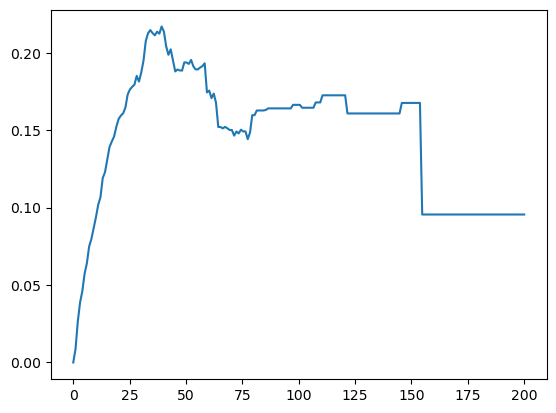

In [47]:
time_grid = np.linspace(durations_test.min(), 200, 200)
_ = ev.brier_score(time_grid).plot()

In [48]:
ev.concordance_td()

0.7989422191431299

In [49]:
ev.integrated_brier_score(time_grid)

0.14594414809625283

In [50]:
ev.integrated_nbll(time_grid)

0.4687066217480888

**Summary of DeepSurv**:
1. Time dependent concordance index = 0.80, 
2. Integrated Brier score = 0.14, and
3. Integrated negative Binomial log-likelihood = 0.49.

### **3.2. Cox Proportional Hazard Regression**

In [51]:
from lifelines import CoxPHFitter

In [52]:
train

,Age,BUN,Creatinine,GCS,Gender,Glucose,HCO3,HCT,HR,ICUType,...,PaCO2,PaO2,Platelets,Temp,Urine,WBC,Weight,pH,Survival,observed
0,85.0,24.0,1.10,8.0,1.0,163.5,22.5,26.85,97.0,1.0,...,12.80,88.0,18.595358,15.304437,0.000000,34.500000,163.500000,7.430000,7.0,0
1,86.0,18.0,1.10,10.0,1.0,141.5,22.0,26.50,75.0,4.0,...,10.15,70.0,71.500000,97.335000,149.000000,33.000000,170.000000,7.450000,24.0,0
2,55.0,15.0,0.85,15.0,1.0,108.5,27.0,22.90,91.0,2.0,...,16.30,74.1,53.000000,70.330000,107.000000,40.000000,163.000000,7.370000,6.0,0
3,86.0,23.0,1.35,14.0,1.0,128.5,25.0,25.50,82.0,2.0,...,16.25,90.4,51.967349,70.794809,115.786769,42.000000,297.000000,7.360000,7.0,0
4,90.0,13.0,0.60,13.0,0.0,109.0,25.0,27.60,70.0,4.0,...,8.85,80.0,53.000000,72.000000,133.000000,40.000000,100.000000,7.460000,10.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9470,84.0,22.5,0.65,12.5,0.0,150.5,27.0,27.50,72.0,2.0,...,9.70,52.3,51.704155,74.365983,122.265712,41.000000,171.000000,7.440000,15.0,0
9471,56.0,17.5,0.90,15.0,1.0,150.5,25.5,43.95,67.5,1.0,...,11.15,98.9,72.000000,90.670000,127.000000,39.979481,140.140722,7.425129,2.0,0
9472,80.0,19.0,0.90,15.0,1.0,105.0,23.5,25.70,87.0,4.0,...,10.70,80.0,45.000000,66.000000,113.000000,36.763109,141.273325,7.443856,6.0,0
9473,84.0,37.0,1.40,14.0,1.0,129.0,22.0,28.80,75.0,3.0,...,16.10,77.5,66.500000,83.000000,119.000000,37.000000,47.000000,7.440000,10.0,0


In [53]:
# Schoenfeld Residuals
cph = CoxPHFitter()
cph.fit(train, duration_col='Survival', event_col='observed')
cph.check_assumptions(train, p_value_threshold=0.05, show_plots=False)

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 9475 total observations, 8144 right-censored observations>
         test_name = proportional_hazard_test

---
                 test_statistic      p  -log2(p)
Age        km              3.45   0.06      3.98
           rank            2.94   0.09      3.53
BUN        km              2.02   0.16      2.68
           rank            0.54   0.46      1.11
Creatinine km              0.93   0.33      1.58
           rank            2.57   0.11      3.20
GCS        km             74.17 <0.005     56.95
           rank           92.49 <0.005     70.32
Gender     km              2.23   0.14      2.88
           rank            4.56   0.03      4.94
Glucose    km              0.28   0.60      0.74
           rank            0.31   0.58      0.80
HCO3       km              0.25   0.62      0.70
           rank            0.05   0.82      0.28
HCT        km              3.58   0.06      4.09
           rank            4.64   0.03      5.00
HR         km             13.11 <0.005     11.74
           rank           17.74 <0.005     15.27
ICUType    km              9.36 <0.005      8.82
           rank            7.60   0.01      7.42
K          km              0.17   0.68      0.56
           rank            1.18   0.28      1.85
Mg         km              0.20   0.66      0.61
           rank            0.05   0.83      0.27
NIDiasABP  km              2.02   0.16      2.69
           rank            0.00   0.99      0.01
NIMAP      km              2.73   0.10      3.34
           rank            2.85   0.09      3.45
NISysABP   km              0.12   0.73      0.45
           rank            0.46   0.50      1.01
Na         km              0.02   0.90      0.15
           rank            1.21   0.27      1.89
PaCO2      km              0.00   0.98      0.02
           rank            0.01   0.91      0.13
PaO2       km              0.98   0.32      1.63
           rank            0.01   0.92      0.12
Platelets  km              1.97   0.16      2.64
           rank            3.79   0.05      4.28
Temp       km              2.08   0.15      2.75
           rank            4.41   0.04      4.81
Urine      km              2.45   0.12      3.09
           rank            3.81   0.05      4.29
WBC        km              0.01   0.91      0.14
           rank            0.31   0.58      0.79
Weight     km              4.89   0.03      5.21
           rank            2.90   0.09      3.50
pH         km              0.26   0.61      0.71
           rank            0.62   0.43      1.21



1. Variable 'GCS' failed the non-proportional test: p-value is <5e-05.

   Advice 1: the functional form of the variable 'GCS' might be incorrect. That is, there may be
non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'GCS' using pd.cut, and then specify it in `strata=['GCS',
...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


2. Variable 'Gender' failed the non-proportional test: p-value is 0.0327.

   Advice: with so few unique values (only 2), you can include `strata=['Gender', ...]` in the call
in `.fit`. See documentation in link [E] below.

3. Variable 'HCT' failed the non-proportional test: p-value is 0.0313.

   Advice 1: the functional form of the variable 'HCT' might be incorrect. Tha

[]

In [54]:
# Fit the model
cph.fit(train, duration_col='Survival', event_col='observed', strata=['ICUType'])
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 9475 total observations, 8144 right-censored observations>
             duration col = 'Survival'
                event col = 'observed'
                   strata = ICUType
      baseline estimation = breslow
   number of observations = 9475
number of events observed = 1331
   partial log-likelihood = -9055.94
         time fit was run = 2024-07-03 11:28:32 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
Age         0.02      1.02      0.00            0.02            0.03                1.02                1.03
BUN         0.01      1.01      0.00            0.01            0.01                1.01                1.01
Creatinine -0.07      0.93      0.03           -0.12           -0.01                0.89                0.99
GCS        -0.14      0.87      0.01           -0.16           -0.13                0.85                0.88
Gender      0.03      1.03      0.06           -0.09            0.14                0.91                1.15
Glucose     0.00      1.00      0.00            0.00            0.00                1.00                1.00
HCO3        0.00      1.00      0.01           -0.03            0.03                0.97                1.03
HCT         0.01      1.01      0.01            0.00            0.03                1.00                1.03
HR          0.01      1.01      0.00            0.01            0.01                1.01                1.01
K           0.03      1.03      0.06           -0.09            0.15                0.91                1.16
Mg          0.14      1.15      0.09           -0.03            0.32                0.97                1.38
NIDiasABP  -0.01      0.99      0.01           -0.02            0.01                0.98                1.01
NIMAP      -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
NISysABP   -0.29      0.75      0.04           -0.38           -0.20                0.69                0.82
Na         -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
PaCO2       0.00      1.00      0.00            0.00            0.01                1.00                1.01
PaO2       -0.01      0.99      0.00           -0.01           -0.00                0.99                1.00
Platelets  -0.01      0.99      0.01           -0.02            0.01                0.98                1.01
Temp       -0.00      1.00      0.01           -0.02            0.02                0.98                1.02
Urine       0.00      1.00      0.00           -0.00            0.01                1.00                1.01
WBC        -0.01      0.99      0.01           -0.02            0.01                0.98                1.01
Weight     -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
pH         -0.50      0.61      0.45           -1.38            0.39                0.25                1.47

            cmp to      z      p  -log2(p)
covariate                                 
Age           0.00  10.48 <0.005     82.91
BUN           0.00   5.67 <0.005     26.04
Creatinine    0.00  -2.49   0.01      6.28
GCS           0.00 -18.39 <0.005    248.36
Gender        0.00   0.43   0.67      0.58
Glucose       0.00   3.42 <0.005     10.62
HCO3          0.00   0.01   0.99      0.02
HCT           0.00   1.98   0.05      4.39
HR            0.00   5.73 <0.005     26.54
K             0.00   0.47   0.64      0.65
Mg            0.00   1.58   0.11      3.12
NIDiasABP     0.00  -0.95   0.34      1.54
NIMAP         0.00  -1.89   0.06      4.10
NISysABP      0.00  -6.50 <0.005     33.56
Na            0.00  -3.65 <0.005     11.91
PaCO2         0.00   2.56   0.01      6.56
PaO2          0.00  -4.89 <0.005     19.91
Platelets     0.00  -1.09   0.28      1.86
Temp     

In [55]:
# Get Survival value
Surv_cox = cph.predict_survival_function(test)

In [56]:
X_test

,Age,BUN,Creatinine,GCS,Gender,Glucose,HCO3,HCT,HR,ICUType,...,NISysABP,Na,PaCO2,PaO2,Platelets,Temp,Urine,WBC,Weight,pH
0,79.0,18.0,0.70,15.0,1.0,110.0,19.0,36.60,102.5,3.0,...,36.40,67.5,13.15,95.3,66.000000,76.000000,111.000000,30.572147,126.333422,7.418131
1,76.0,15.5,0.70,6.0,1.0,74.0,21.0,32.50,83.0,3.0,...,35.80,120.0,6.20,75.0,56.500000,76.000000,111.500000,42.500000,153.500000,7.330000
2,87.0,29.0,1.05,11.0,0.0,110.5,16.0,32.60,107.0,4.0,...,38.00,31.0,14.35,3.4,84.000000,94.000000,120.000000,24.000000,183.000000,7.420000
3,31.0,108.5,2.30,9.0,0.0,100.5,25.0,25.00,119.5,3.0,...,37.90,90.0,4.40,95.7,75.000000,88.000000,135.500000,48.500000,119.000000,7.385000
4,84.0,7.0,0.75,14.0,0.0,114.0,21.5,29.10,63.5,4.0,...,37.50,45.0,12.70,57.0,38.000000,78.335000,155.000000,39.000000,110.000000,7.355000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2364,66.0,18.5,1.20,15.0,1.0,115.5,29.0,39.15,113.0,2.0,...,37.30,40.0,10.75,102.0,55.000000,73.330000,108.000000,45.561994,113.864368,7.439691
2365,73.0,40.0,2.50,10.0,1.0,204.0,29.0,32.80,80.0,3.0,...,36.50,10.0,8.90,87.3,59.000000,71.000000,112.000000,44.000000,108.000000,7.460000
2366,50.0,12.5,0.45,15.0,0.0,108.0,26.0,31.10,107.0,3.0,...,36.95,300.0,12.20,80.0,57.000000,70.500000,107.000000,36.661091,135.458400,7.506874
2367,71.0,14.0,1.00,15.0,1.0,106.0,26.0,31.30,87.5,2.0,...,37.30,42.5,14.50,85.9,45.000000,64.000000,101.000000,44.000000,166.000000,7.390000


In [71]:
Surv_cox

,27,40,53,67,70,72,73,84,93,105,...,2324,2326,2329,2330,2331,2339,2340,2343,2347,2359
-23.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1.0,0.985377,0.996377,0.999088,0.995635,0.990300,0.997502,0.998227,0.989921,0.996812,0.997715,...,0.997506,0.998739,0.990727,0.982295,0.956939,0.998574,0.990145,0.993557,0.988074,0.993952
2.0,0.944041,0.985912,0.996440,0.983046,0.962614,0.990272,0.993087,0.961173,0.987595,0.991096,...,0.990870,0.995378,0.966364,0.936499,0.850733,0.994774,0.964278,0.976539,0.956894,0.977967
3.0,0.911002,0.977296,0.994244,0.972702,0.940189,0.984301,0.988834,0.937912,0.979997,0.985627,...,0.986009,0.992908,0.948796,0.904126,0.780094,0.991984,0.945652,0.964187,0.934550,0.966354
4.0,0.889838,0.971652,0.992798,0.965937,0.925679,0.980381,0.986038,0.922873,0.975016,0.982035,...,0.982441,0.991091,0.936048,0.880976,0.731797,0.989931,0.932149,0.955180,0.918410,0.957879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202.0,0.010669,0.326698,0.754882,0.259708,0.049576,0.462652,0.578706,0.044053,0.373721,0.494001,...,0.785764,0.885336,0.406804,0.178234,0.014270,0.871336,0.384339,0.535756,0.314014,0.556735
295.0,0.010669,0.326698,0.754882,0.259708,0.049576,0.462652,0.578706,0.044053,0.373721,0.494001,...,0.785764,0.885336,0.406804,0.178234,0.014270,0.871336,0.384339,0.535756,0.314014,0.556735
363.0,0.010669,0.326698,0.754882,0.259708,0.049576,0.462652,0.578706,0.044053,0.373721,0.494001,...,0.785764,0.885336,0.406804,0.178234,0.014270,0.871336,0.384339,0.535756,0.314014,0.556735
454.0,0.010669,0.326698,0.754882,0.259708,0.049576,0.462652,0.578706,0.044053,0.373721,0.494001,...,0.785764,0.885336,0.406804,0.178234,0.014270,0.871336,0.384339,0.535756,0.314014,0.556735


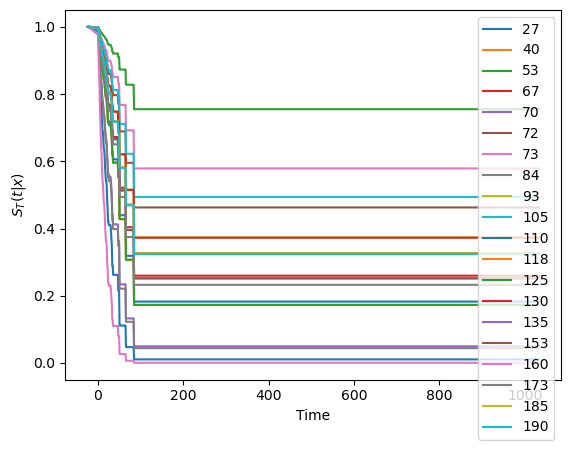

In [57]:
# Plot the Survival function
Surv_cox.iloc[:, :20].plot()
plt.ylabel('$S_T(t | x)$')
_ = plt.xlabel('Time')

In [58]:
ev_cox = EvalSurv(Surv_cox, durations_test, events_test, censor_surv='km')

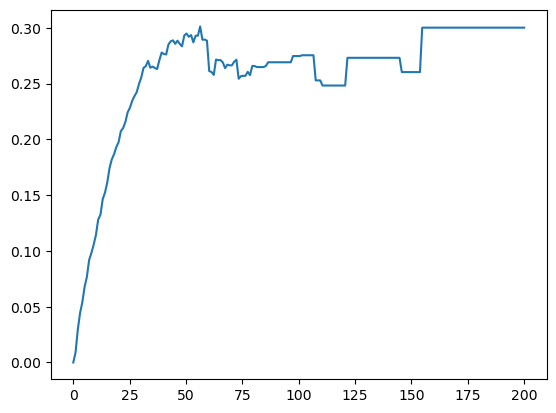

In [59]:
_ = ev_cox.brier_score(time_grid).plot()

In [60]:
ev_cox.concordance_td()

0.5083279120656298

In [61]:
ev_cox.integrated_brier_score(time_grid)

0.258588056735531

In [62]:
ev_cox.integrated_nbll(time_grid)

0.7331330078840782

**Conclusion:**
1. Time-dependent C-index: 0.51
2. Integrated Brier score: 0.42
3. Integrated negative Binomial log-likelihood: 1.08